In [1]:
!pip install shap
# !pip install tensorflow==2.4.3
import shap
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import train_test_split
# from genericpath import isfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
dataset = 'TrafficLabelling/'# TrafficLabelling lycos-ids2017

path = '/content/drive/MyDrive/dataset/'+dataset
os.chdir(path)
os.chdir('..')

In [3]:
f = 'C'
if dataset == 'lycos-ids2017/':
  dataset_clean = pd.read_csv(path + 'dataset_clean_exp_atrib.csv', index_col=[0])
  dataset_clean = pd.get_dummies(dataset_clean, columns=['ip_prot'],drop_first=True)

  # Comentar caso use Pd = 6
  dataset_clean_cat = pd.read_csv(path + 'pd4.csv', index_col=[0])
  dataset_clean = pd.concat([dataset_clean_cat, dataset_clean.loc[:,np.invert(dataset_clean.columns.str.contains('[sd]port'))]], axis=1)
  del dataset_clean_cat

  Id = dataset_clean.columns.str.contains('[sd]addr')
  Id = dataset_clean.columns[Id].to_list()
  Pd = dataset_clean.columns.str.contains('[sd]port')
  Pd = dataset_clean.columns[Pd].to_list()

  Ie = dataset_clean.columns.str.match('(src_addr)|(dst_addr)')
  Ie = dataset_clean.columns[Ie].to_list()
  Pe = dataset_clean.columns.str.match('(src_port)|(dst_port)')
  Pe = dataset_clean.columns[Pe].to_list()

  C = np.setdiff1d(dataset_clean.columns,Id+Pd+Ie+Pe+['label','flow_id','timestamp']).tolist()
  Cs = ['flow_duration', 'down_up_ratio', 'pkt_len_max', 'bytes_per_s', 'pkt_per_s', 'fwd_pkt_cnt', 'fwd_pkt_len_tot', 'fwd_pkt_len_max'] + dataset_clean.columns[dataset_clean.columns.str.contains('prot')].to_list()

  # comb_f = {'CPe':C+Pe,'CPd'+str(int(len(Pd)/2)):C+Pd,'PeIe':Pe+Ie,'Pd'+str(int(len(Pd)/2))+'Ie':Pd+Ie,'Pd'+str(int(len(Pd)/2))+'Id'+str(int(len(Id)/2)):Pd+Id,'CPd'+str(int(len(Pd)/2))+'Ie':C+Pd+Ie,'CPd'+str(int(len(Pd)/2))+'Id'+str(int(len(Id)/2)):C+Pd+Id,'C':C,'CPeIe':C+Pe+Ie,'CPd'+str(int(len(Pd)/2))+'_dest':C+Pd[-int(len(Pd)/2):],'CPe_dest':C+Pe[-6:],'Cs':Cs,'CsPd'+str(int(len(Pd)/2))+'_dest':Cs+Pd[-int(len(Pd)/2):]}
  comb_f = {'CPdId':C+Pd+Id,'C':C,'CPeIe':C+Pe+Ie,'CPd_dest':C+Pd[-int(len(Pd)/2):],'Cs':Cs,'CsPd'+str(int(len(Pd)/2))+'_dest':Cs+Pd[-int(len(Pd)/2):]} # para manter compatibilidade com o TrafficLabelling
  # f = 'CPd'+str(int(len(Pd)/2))+'Id'+str(int(len(Id)/2))
  # for f in comb_f:
  #   print(f, comb_f[f])

  # f = 'C'
  rest_cols = comb_f[f]

elif dataset == 'TrafficLabelling/':
  C = ['Protocol', 'FlowDuration', 'TotalFwdPackets', 'TotalBackwardPackets', 'TotalLengthofFwdPackets', 'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin', 'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax', 'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd', 'FlowBytes/s', 'FlowPackets/s', 'FlowIATMean', 'FlowIATStd', 'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd', 'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd', 'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags', 'FwdURGFlags', 'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets/s', 'BwdPackets/s', 'MinPacketLength', 'MaxPacketLength', 'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance', 'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount', 'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount', 'Down/UpRatio', 'AveragePacketSize', 'AvgFwdSegmentSize', 'AvgBwdSegmentSize', 'SubflowFwdPackets', 'SubflowFwdBytes', 'SubflowBwdPackets', 'SubflowBwdBytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward', 'ActiveMean', 'ActiveStd', 'ActiveMax', 'ActiveMin', 'IdleMean', 'IdleStd', 'IdleMax', 'IdleMin']

  Cs = ['Protocol', 'ACKFlagCount', 'ActiveMean', 'ActiveMin', 'AveragePacketSize', 'BwdIATMean', 'BwdPacketLengthMin', 'BwdPacketLengthStd',
              'BwdPackets/s', 'FwdIATMean', 'FwdIATMin', 'FwdPacketLengthMean', 'FwdPackets/s', 'FwdPSHFlags', 'FlowDuration', 'FlowIATMean',
              'FlowIATMin', 'FlowIATStd', 'Init_Win_bytes_backward', 'Init_Win_bytes_forward', 'PSHFlagCount', 'SubflowFwdBytes', 'SYNFlagCount',
              'TotalLengthofFwdPackets']

  Pd = ['sPort0', 'sPort1', 'sPort2', 'sPort3', 'sPort4', 'sPort5', 'dPort0',
        'dPort1', 'dPort2', 'dPort3', 'dPort4', 'dPort5']

  Id = ['sIP0', 'sIP1', 'sIP2', 'sIP3', 'dIP0', 'dIP1', 'dIP2', 'dIP3']

  # Ie = dataset_clean.columns.str.match('(SourceIP)|(DestinationIP)')
  # Ie = dataset_clean.columns[Ie].to_list()
  Ie = ['SourceIP_DNS_int', 'SourceIP_Reverse_proxy', 'SourceIP_Web_Server_int', 'SourceIP_ext', 'DestinationIP_DNS_int', 'DestinationIP_Reverse_proxy', 'DestinationIP_Web_Server_int', 'DestinationIP_b_m_cast', 'DestinationIP_ext']
  # Pe = dataset_clean.columns.str.match('(SourcePort)|(DestinationPort)')
  # Pe = dataset_clean.columns[Pe].to_list()
  Pe = ['SourcePort_444', 'SourcePort_80', 'SourcePort_8080', 'SourcePort_dynamic', 'SourcePort_registered', 'SourcePort_system', 'DestinationPort_444', 'DestinationPort_80', 'DestinationPort_8080', 'DestinationPort_dynamic', 'DestinationPort_registered', 'DestinationPort_system']
  comb_f = {'CsPe':Cs+Pe,'CPe':C+Pe,'CsPd':Cs+Pd,'CPd':C+Pd,'PeIe':Pe+Ie,'PdIe':Pd+Ie,'PdId':Pd+Id,'CsPdIe':Cs+Pd+Ie,'CsPdId':Cs+Pd+Id,'CPdIe':C+Pd+Ie,'CPdId':C+Pd+Id,'C':C,'Cs':Cs,'CPeIe':C+Pe+Ie,'CPd_dest':C+Pd[-6:]}
  # f = 'CPdId'
  rest_cols = comb_f[f]

  # dataset_clean = pd.read_csv(path + 'dataset_clean_exp_atrib.csv', index_col=[0])
  dataset_clean = pd.read_csv(path + 'dataset_clean_exp_atrib.csv', usecols=rest_cols+['Label'])
  dataset_clean.rename(columns={'Label':'label'}, inplace=True)

In [4]:
# f = 'C'
# rest_cols = comb_f[f]
labels = dataset_clean['label']
features = dataset_clean.loc[:, rest_cols].astype('float64')
del dataset_clean
LE = LabelEncoder()
LE.fit(labels)
labels = LE.transform(labels)

features_train_val, features_test, labels_train_val, labels_test = train_test_split(features, labels, test_size=.2, random_state=42, stratify=labels)

features_train, features_val, labels_train, labels_val = train_test_split(features_train_val, labels_train_val, test_size=.2, random_state=42, stratify=labels_train_val)

m_train = features_train.shape[0]
m_val = features_val.shape[0]
m_test = features_test.shape[0]
m = labels.shape[0]

scaler = StandardScaler()
scaler.fit(features_train)
# features_val2 = features_val.copy()
features_train = pd.DataFrame(scaler.transform(features_train), index=features_train.index,columns=features_train.columns)
# features_train_val = scaler.transform(features_train_val)
features_val = pd.DataFrame(scaler.transform(features_val), index=features_val.index,columns=features_val.columns)
features_test = pd.DataFrame(scaler.transform(features_test), index=features_test.index,columns=features_test.columns)

del features_train_val
del labels_train_val

In [5]:
# # caso multiclasse
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(27, input_dim=features.shape[1], activation='relu'),
#     tf.keras.layers.Dense(30, activation='relu'),
#     tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')
# ])

# model.compile(optimizer='adam',
#             loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])

# model_name = 'multi_'+f+'.h5'
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
# mc = tf.keras.callbacks.ModelCheckpoint(path+'saved_models/'+model_name, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# model.fit(features_train, # cat s/ gpu demora mais de 25 min
#           labels_train,
#           epochs=100,
#           verbose=0,
#           batch_size = 256,
#           validation_data=(features_val, labels_val),
#           callbacks=[es, mc])
# model_path = path+'saved_models/multi_'+f
# model_multi = tf.keras.models.load_model(model_path+'.h5')
# model.evaluate(features_test, labels_test, verbose=0)

In [6]:
model_path = path+'saved_models/bin_'+f
model = tf.keras.models.load_model(model_path+'.h5')
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
shap_type = 'nn_bkp'

# _, train_acc = model.evaluate(features_train, labels_train>0, verbose=0)
# _, val_acc = model.evaluate(features_val, labels_val>0, verbose=0)
# _, test_acc = model.evaluate(features_test, labels_test>0, verbose=0)
# # print('Acurácias (%):\nTeste: {:2.4f}'.format(100*test_acc))
# print('Acurácias (%):\nTreino: {:2.4f}\nValidação: {:2.4f}\nTeste: {:2.4f}'.format(100*train_acc,100*val_acc,100*test_acc))

features = {'train':features_train,'val':features_val, 'test':features_test}
labels = {'train':labels_train, 'val':labels_val, 'test':labels_test}


the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)


Usando somente a confiança:   5559 FP em 110687 exemplos (5.02%)


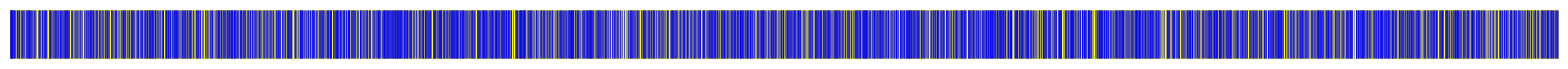

Usando somente a confiança:   1355 FP em 27717 exemplos (4.89%)


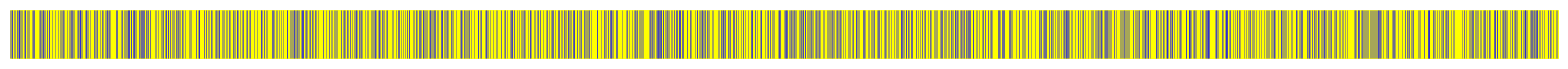

Usando somente a confiança:   1735 FP em 34685 exemplos (5.00%)


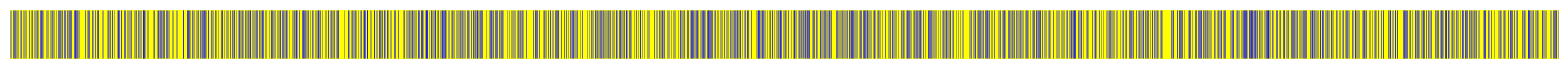

In [7]:
modo = 'pca' # cos
shap_path = path+'shap/'+f+'/'+shap_type+'/'
seed = 42

for cj in ['train', 'val', 'test']:  

  # prediction = model.predict(features[cj]).squeeze() # com gpu
  prediction = tf.squeeze(model(features[cj].values)).numpy()

  msc_p = prediction > 0.5
  msc_fp = msc_p & (labels[cj] == 0)
  if cj == 'train':
    if dataset+f == 'TrafficLabelling/CPdId':
      conf_limiar = prediction[msc_fp].max()
    else:
      conf_limiar = np.percentile(prediction[msc_fp],99, interpolation='higher')
    msc_p_train = msc_p & (prediction <= conf_limiar)
    dl = {}

  msc_p = msc_p & (prediction <= conf_limiar) # diferente do adversarial, pois aqui é só o que está abaixo do limiar
  filename = shap_path+'shap_values_'+cj+'.npy'

  if os.path.exists(filename):
    shap_values = np.load(filename)
  elif shap_type.startswith('kernel'):
    link='identity'
    if shap_type.endswith('_k'):
      background = shap.kmeans(features['train'][msc_p_train],50)
    else:
      background = shap.sample(features['train'][msc_p_train], 100,random_state=seed)
    explainer = shap.KernelExplainer(model, background, link=link)
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore")
      shap_values = explainer.shap_values(features[cj][msc_p])[0]
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    np.save(filename, shap_values)
  elif shap_type == 'nn_e_train':
    explainer = shap.DeepExplainer(model, shap.sample(features['train'], 4000,random_state=seed).values)
    # explainer = shap.DeepExplainer(model, shap.sample(features['train'][msc_p_train], 4000,random_state=seed).values)
    shap_values = explainer.shap_values(features[cj][msc_p].values)[0]
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    np.save(filename, shap_values)

  labels2 = labels[cj][msc_p,np.newaxis] == 0
  cf_fp, cf_size = labels2.sum(), labels2.shape[0]
  print('Usando somente a confiança: {:>6d} FP em {:>4d} exemplos ({:2.2f}%)'.format(cf_fp, cf_size, 100*cf_fp/cf_size))
  if modo == 'cos':
    if cj == 'train':
      VP = shap_values[labels[cj][msc_p] != 0].mean(axis=0)
      FP = shap_values[labels[cj][msc_p] == 0].mean(axis=0)
      vp_fp = np.array([VP, FP])

      # Similaridade entre a média dos gradientes (VP e FP) no conjunto treino
      print('Similaridade:',float(cosine_similarity(VP[np.newaxis,:], FP[np.newaxis,:])))
      # Normas das médias dos gradientes (VP e FP) no conjunto treino
      norma_vp_fp = np.linalg.norm(vp_fp, axis=1)
      print('||VP|| = {}\n||FP|| = {}'.format(norma_vp_fp[0],norma_vp_fp[1]))

    dados = np.concatenate((prediction[msc_p,np.newaxis],cosine_similarity(shap_values, vp_fp), np.linalg.norm(shap_values,axis=1, keepdims=True),labels2), axis=1)
    dados = pd.DataFrame(dados, index=features[cj][msc_p].index, columns=['Confiança','cos(\u03B8)\u2207_VP','cos(\u03B8)\u2207_FP','||\u2207||','FP?'])

    # cj='test'
    refin = 0  
    adv_fp, adv_size = (((dados['cos(\u03B8)\u2207_FP']-dados['cos(\u03B8)\u2207_VP'])>=refin) & dados['FP?']).sum(), ((dados['cos(\u03B8)\u2207_FP']-dados['cos(\u03B8)\u2207_VP'])>=refin).sum()
    # cf_idx = dados[dados['FP?']].iloc[-adv_fp].name
    # cf_idx_size = cf_size - np.flatnonzero(dados.index == cf_idx).squeeze()
    print('Usando confiança + SHAP: {:>9d} FP em {:>4d} exemplos ({:2.2f}%)'.format(adv_fp, adv_size, 100*adv_fp/adv_size))
    # print('A partir do menos confiável: {:>5d} FP em {:>4d} exemplos ({:2.2f}%)'.format(adv_fp, cf_idx_size, 100*adv_fp/cf_idx_size))

  elif modo == 'pca':
    shap_values = features[cj][msc_p].values
    dados = np.concatenate((prediction[msc_p,np.newaxis],shap_values, labels2), axis=1)
    dados = pd.DataFrame(dados, index=features[cj][msc_p].index, columns=['Confiança']+features[cj].columns.tolist()+['FP?'])
    # dados = pd.concat([features[cj][msc_p],pd.DataFrame(labels2,index=features[cj][msc_p].index, columns=['FP?'])],axis=1)
  
  elif modo == 'pca_9':
    # shap_values = features[cj][msc_p].values
    if cj == 'train':
      from sklearn.decomposition import PCA
      n=9
      pca = PCA(n_components=n, random_state=seed)
      pca.fit(shap_values)

    shap_values = pca.transform(shap_values)
    dados = np.concatenate((prediction[msc_p,np.newaxis],shap_values, labels2), axis=1)
    dados = pd.DataFrame(dados, index=features[cj][msc_p].index, columns=['Confiança']+['pca'+str(i) for i in range(n)]+['FP?'])
  
  # dados.sort_values('Confiança',ascending=False,inplace=True)
  dados = dados.astype({'FP?': 'bool'})

  dl[cj] = dados

  idxs = [np.flatnonzero(np.invert(dados['FP?'])), np.flatnonzero(dados['FP?'])]
  colors = ['yellow', 'b']
  fig = plt.figure(figsize=(16,.76))
  for i, c in zip(idxs, colors):
    plt.scatter(i, np.zeros(i.shape[0]), marker='|',c=c, s=1240, alpha=.5,linewidth=.5)
  idxs[0] = idxs[0][idxs[0] >= np.min([idxs[1][0]-1, dl[cj].index[0]])]
  fig.tight_layout(pad=0)
  plt.axis('off')
  plt.margins(0,0)
  # plt.savefig(path+'fig/'+f+'/conf_'+str.lower(cj+'_'+f)+'.png', bbox_inches='tight',dpi=200, transparent=True,pad_inches=0)
  plt.show()


  

In [ ]:
dl2['FP?'] = dl2['FP?'].astype(bool)

In [ ]:
dl2.sort_values(by=['Conf2'], inplace=True)

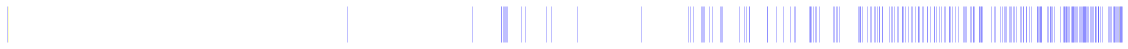

In [ ]:
idxs = [np.flatnonzero(np.invert(dl2['FP?'])), np.flatnonzero(dl2['FP?'])]
colors = ['yellow', 'b']
idxs[0] = idxs[0][[0,-1]]
fig = plt.figure(figsize=(16,.76))
for i, c in zip(idxs, colors):
  plt.scatter(i, np.zeros(i.shape[0]), marker='|',c=c, s=1240, alpha=.5,linewidth=.5)
# idxs[0] = idxs[0][idxs[0] >= np.min([idxs[1][0]-1, dl[cj].index[0]])]
fig.tight_layout(pad=0)
plt.axis('off')
plt.margins(0,0)
# plt.savefig(path+'fig/'+f+'/conf_'+str.lower(cj+'_'+f)+'dl2.pdf', bbox_inches='tight',dpi=200, transparent=False,pad_inches=0)
plt.show()

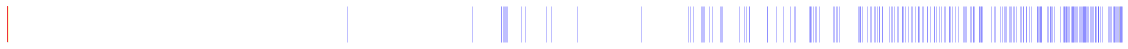

In [ ]:
# idxs = [np.flatnonzero(np.invert(dados['FP?'])), np.flatnonzero(dados['FP?'])]
# idxs[0] = idxs[0][[0,-1]]
# idxs[1] = idxs[1][fp_zimo-1:]
# idxs[0] = idxs[0][idxs[0] >= np.min([idxs[1][0]-1, dl[cj].index[0]])]
fig = plt.figure(figsize=(16,.76))
for i, c in zip(idxs, colors):
  plt.scatter(i, np.zeros(i.shape[0]), marker='|',c=c, s=1240, alpha=.5,linewidth=.5)
# idxs[0] = idxs[0][idxs[0] >= np.min([idxs[1][0]-1, dl[cj].index[0]])]
# plt.scatter(dl.index[0], 0, marker='|',c='r', s=1240)
plt.scatter(dados.shape[0] - dl[cj].shape[0], 0, marker='|',c='r', s=1240)
fig.tight_layout(pad=0)
plt.axis('off')
# plt.box(on=False)
plt.yticks([])
plt.margins(0,0)
# plt.savefig(path+'fig/'+f+'/conf_'+str.lower(cj+'_'+f)+'_solo.pdf', bbox_inches='tight',dpi=200, transparent=True,pad_inches=0)
plt.show()

In [ ]:
# dl2.loc[dl2['Conf2'] == 0,'FP?'].sum()

19.87 * 0.5455659991826727

10.840396403759707

In [ ]:
# FP cometidos pela rede multiclasse

cj = 'val'
prediction_multi = tf.squeeze(model_multi(features[cj].loc[dl[cj].index[dl[cj]['FP?'].values]].values)).numpy()
prediction_multi = np.argmax(prediction_multi,axis=-1)
LE.inverse_transform(np.unique(prediction_multi))
unique, counts = np.unique(prediction_multi,return_counts=True)
print(LE.inverse_transform(unique),'\n',counts)

['benign' 'dos_goldeneye' 'dos_slowhttptest' 'dos_slowloris' 'portscan'
 'ssh_patator' 'webattack_bruteforce'] 
 [  6 121  70   2   9   1   1]


In [ ]:
shap.initjs()
shap.plots.force(explainer.expected_value.numpy(),shap_values.iloc[1].values,features = data_to_explain.iloc[1])

In [ ]:
shap.initjs()
shap.plots.force(explainer.expected_value.numpy(),shap_values_fp.iloc[1].values,features = data_to_explain_fp.iloc[1])

In [ ]:
shap_values_fp[shap_values_fp.columns[shap_values_fp.where(shap_values_fp >= 0,1).min() < shap_values.where(shap_values >= 0,1).min()]]

,bwd_non_empty_pkt_cnt,bwd_pkt_hdr_len_min,bwd_tcp_init_win_bytes,flag_ece,fwd_flag_psh
75067,0.000187,0.003876,-0.050980,0.000496,0.008320
602540,0.000243,0.042066,0.006968,0.000292,0.002025


In [ ]:
shap_values.where(shap_values <= 0,-1).max().loc['fwd_tcp_init_win_bytes']

-0.033567233465378675

In [ ]:
shap_values_fp[shap_values_fp.columns[shap_values_fp.min() < shap_values.min()]]

,bwd_pkt_hdr_len_min,bwd_pkt_per_s,flag_ece,flag_fin,flag_rst,fwd_bulk_bytes_mean,iat_min,pkt_len_mean,pkt_len_var
75067,0.003876,-0.015269,0.000496,0.061081,0.002676,0.001164,-0.127419,-0.014345,-0.007645
602540,0.042066,-0.027063,0.000292,-0.153911,-0.004431,-0.000037,0.005775,-0.024387,-0.031858


In [ ]:
shap_values.max().loc['flag_ece']

0.0004943238055228693

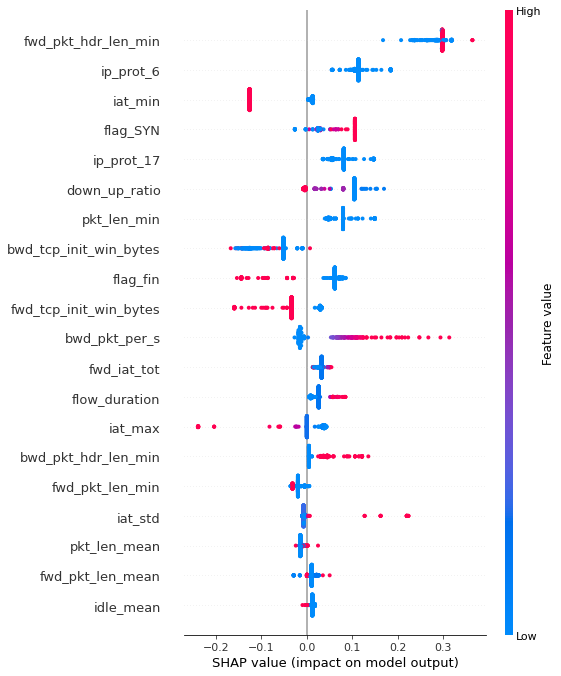

In [ ]:
# fig = shap.summary_plot(shap_values.append(shap_values_fp).values, data_to_explain.append(data_to_explain_fp), show=False)
# plt.savefig('/content/drive/MyDrive/dataset/lycos-ids2017/shap/C/fig.png', bbox_inches='tight',dpi=200, transparent=True,pad_inches=0)

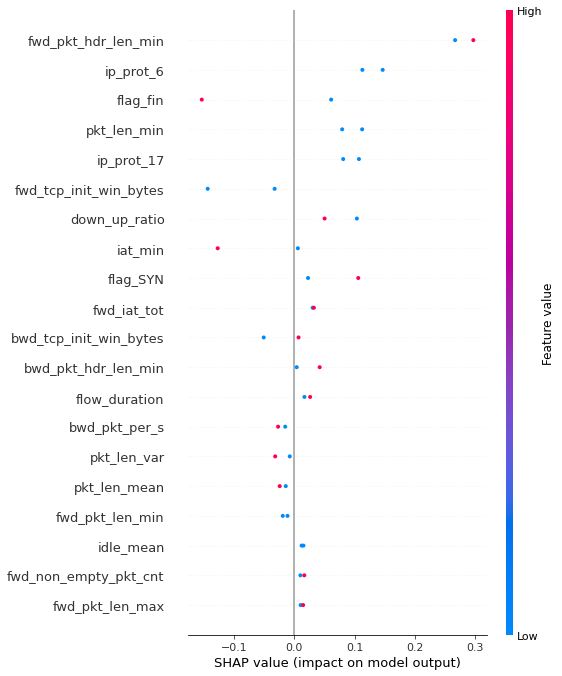

In [ ]:
# index dos fps

slowloris_dl_fp = features[cj].loc[dl[cj].index[dl[cj]['FP?'].values]].index[prediction_multi == LE.transform(['dos_slowloris'])[0]]
data_to_explain_fp = features[cj].loc[slowloris_dl_fp]
shap_values_fp = dl[cj].loc[slowloris_dl_fp].iloc[:,1:-1]
fig = shap.summary_plot(shap_values_fp.values, data_to_explain_fp, show=False)
# plt.savefig('/content/drive/MyDrive/dataset/lycos-ids2017/shap/C/fig3.pdf', bbox_inches='tight',dpi=200, transparent=True,pad_inches=0)

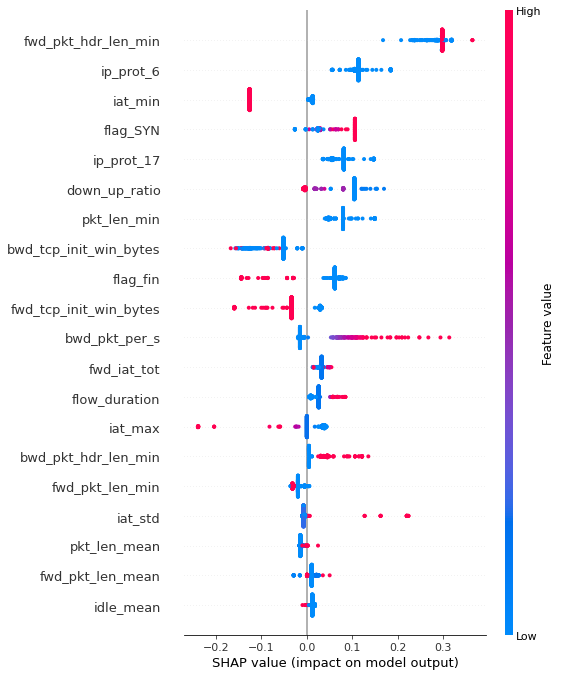

In [ ]:
slowloris = features[cj][labels[cj] == LE.transform(['dos_slowloris'])[0]].index.copy()
slowloris_dl = dl[cj].index[dl[cj].index.isin(slowloris)]
data_to_explain = features[cj].loc[slowloris_dl].copy()
shap_values = dl[cj].loc[slowloris_dl].iloc[:,1:-1].copy()
shap.summary_plot(shap_values.values, data_to_explain)

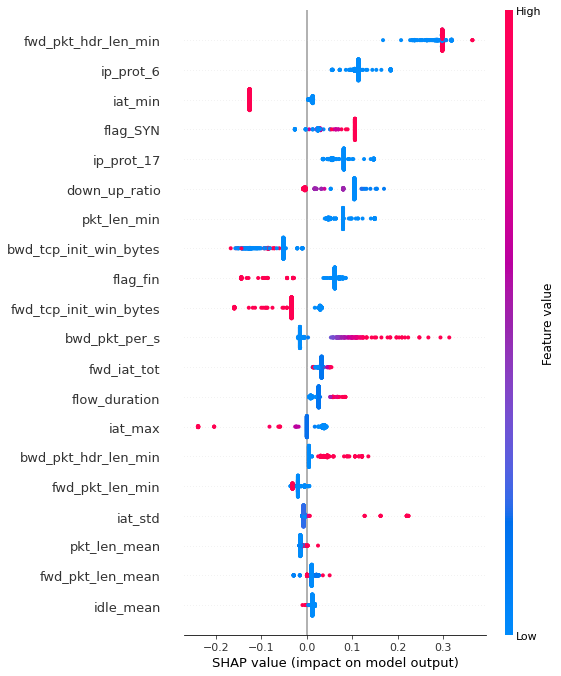

In [ ]:
# fig = shap.summary_plot(shap_values.values, data_to_explain, show=False)
# plt.savefig('/content/drive/MyDrive/dataset/lycos-ids2017/shap/C/fig.pdf', bbox_inches='tight',dpi=200, transparent=True,pad_inches=0)

In [ ]:
# import seaborn as sns
# from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_iter=2000, random_state=42, verbose=0)

# # atb comum
# tsne_res = tsne.fit_transform(features_val[msc_p])
# tsne_res = np.concatenate((tsne_res, labels2), axis=1)
# tsne_res = pd.DataFrame(tsne_res, index=features_val[msc_p].index, columns=['1ª Dimensão', '2ª Dimensão', 'FP?'])

tsne_res = tsne.fit_transform(features[cj][:,:atb])
tsne_res = np.concatenate((tsne_res, pd.DataFrame(labels[cj])), axis=1)
tsne_res = pd.DataFrame(tsne_res, index=labels[cj].index, columns=['1ª Dimensão', '2ª Dimensão', 'FP?'])

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


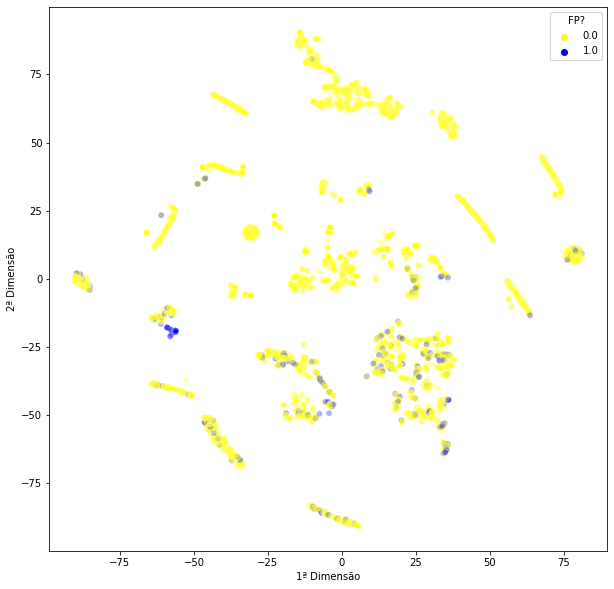

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x='1ª Dimensão', y='2ª Dimensão',
    data=tsne_res, hue='FP?', legend='full', alpha=0.3, palette=['yellow','blue']
)
plt.show()

In [ ]:
tsne_res.loc[slowloris_dl,['FP?']] = 2.0

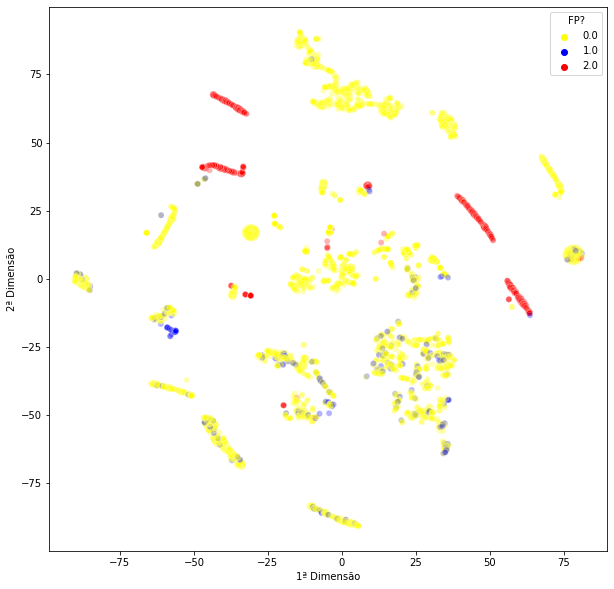

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x='1ª Dimensão', y='2ª Dimensão',
    data=tsne_res, hue='FP?', legend='full', alpha=0.3, palette=['yellow','blue', 'red']
)
plt.show()

In [ ]:
tsne_res.loc[slowloris_dl_fp]

,1ª Dimensão,2ª Dimensão,FP?
75067,63.556416,-13.349484,1.0
602540,9.371842,32.074486,1.0


In [ ]:
shap_values = np.load('/content/drive/MyDrive/dataset/TrafficLabelling/shap/CPeIe/features_val_fp/shap_values.npy')

In [ ]:
shap_values = dl['val'].iloc[dl['val']['FP?'].values,1:-1]

In [ ]:
data_to_explain = features[cj][msc_fp]#.loc[shap_values.index]

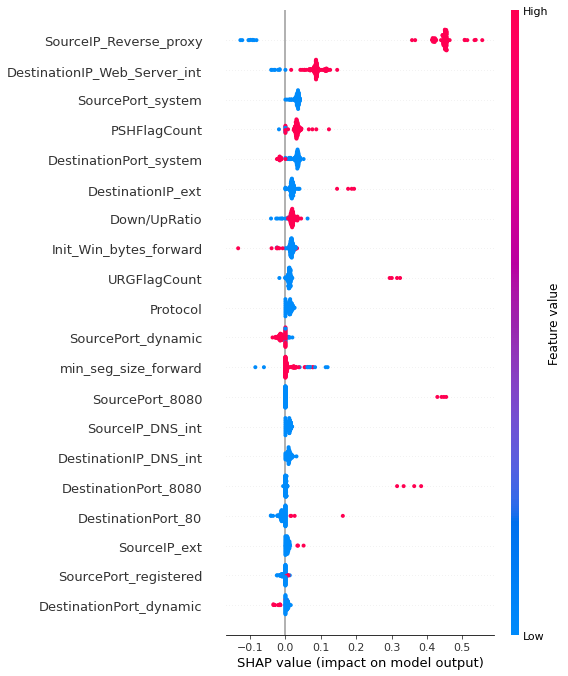

In [ ]:
# Plot shap values
fig = shap.summary_plot(shap_values, data_to_explain, show=False)
# plt.savefig('/content/drive/MyDrive/dataset/TrafficLabelling/shap/CPeIe/features_val_fp/fig.pdf', bbox_inches='tight',dpi=200, transparent=True,pad_inches=0)

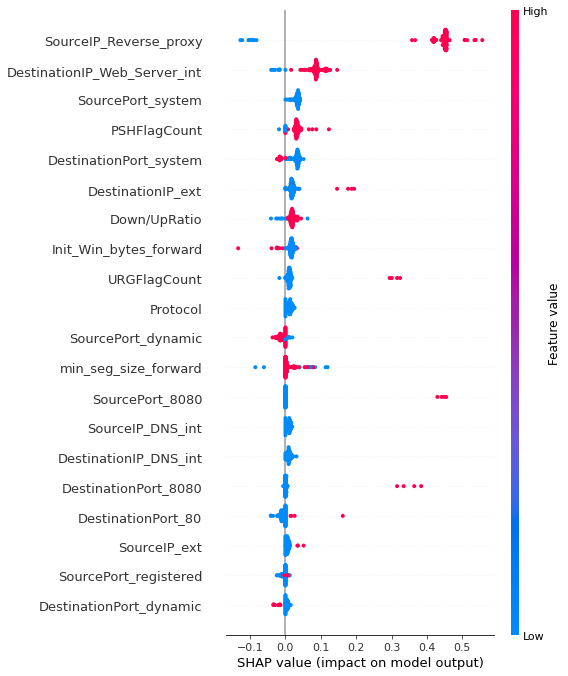

In [ ]:
shap.summary_plot(shap_values, data_to_explain)

In [ ]:
## Trafficlabel
# CPdId = 0.9797166711233629
# CPeIe = 0.9980345986280819
# CPd_dest = 0.9694231848869089
# C = 0.9338523392364516

## Lycos
# CPdId = 0.9289792803264058
# CPeId = 0.9443879513875797
# CPd_dest = 0.9302368809190594
# C = 0.9080919575547736

# pca.explained_variance_ratio_.sum()

0.9080919575547736

In [8]:
labels['train'] = dl['train']['FP?']
features['train'] = dl['train'].iloc[:, :-1]
# LE.fit(labels['train'])
# labels['train'] = LE.transform(labels['train'])
scaler.fit(features['train'])
features['train'] = scaler.transform(features['train'])
labels['val'] = dl['val']['FP?']
features['val'] = dl['val'].iloc[:, 0:-1]
# labels['val'] = LE.transform(labels['val'])
features['val'] = scaler.transform(features['val'])

labels['test'] = dl['test']['FP?']
features['test'] = dl['test'].iloc[:, 0:-1]
# labels['test'] = LE.transform(labels['test'])
features['test'] = scaler.transform(features['test'])

In [9]:
cj='test'
if (dataset == 'TrafficLabelling/') & (f in ['C','CPd_dest']):
  p = np.linspace(0,.25,11)
else:
  p = np.linspace(0,1,11)
dl1 = dl[cj].sort_values(by=['Confiança','FP?'],ascending=[False,False])
fracoes = dl1.shape[0]*p
fracoes = fracoes.round().astype(int)[1:]
print(p)
print(fracoes)

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ]
[ 867 1734 2601 3468 4336 5203 6070 6937 7804 8671]


In [10]:
# for i in fracoes:
#   print((dl[cj].iloc[-i:,-1]).sum())
tot_fp = msc_fp.sum()

dx = p[2]-p[1]
cj_analise = np.zeros(fracoes.shape,dtype='int')
for i,j in enumerate(fracoes):
    cj_analise[i] = dl1.iloc[-j:,-1].sum()
print(cj_analise)
print('AUC: {:.3f}'.format(np.trapz(cj_analise/tot_fp, dx=dx)/((len(cj_analise)-1)*dx)))

[ 199  240  365  365  529  558  691  724  915 1035]
AUC: 0.318


In [11]:
# a = np.array([0.306228374,0.41349481,0.602941176,0.717128028,0.722318339,0.725778547,0.76384083,0.797577855,0.807093426,0.809688581])
# print('AUC: {:.3f}'.format(np.trapz(a, dx=dx)/((len(a)-1)*dx)))

In [1]:
segunda = 'knn' # mlp
rodadas = 20



if modo == 'pca_9':
  atbs = np.floor(np.linspace(0,dados.shape[1]-1,4)[1:]).astype(int)
else:
  atbs = [dados.shape[1]-1]# colocar 1 antes

# atb = dados.shape[1]-1 # 1 para apenas confinça, 4 para confiança + aprox adv
# atb = 1 # 1 para apenas confinça, 4 para confiança + aprox adv
# atbs = [1]
for atb in atbs[-1:]:
  cj_analise = np.zeros(fracoes.shape)

  if segunda == 'mlp':
    dl2 = np.zeros(labels[cj].shape)
    for n in range(rodadas):
      model2 = tf.keras.models.Sequential([
          tf.keras.layers.Dense(10, input_dim=features['train'][:,:atb].shape[1], activation='relu'),
          tf.keras.layers.Dense(10, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
      ])

      model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
      es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)
      model2.fit(features['train'][:,:atb], # cat s/ gpu demora mais de 25 min
                labels['train'],
                epochs=150,
                verbose=0,
                batch_size = 256,
                validation_data=(features['val'][:,:atb], labels['val']),
                callbacks=[es])  
        
      dl2 += model2.predict(features[cj][:,:atb]).squeeze()
      
    dl2 = dl2/rodadas
    print(segunda)

  elif segunda == 'knn':
    from sklearn.neighbors import KNeighborsClassifier
    fracoes_val = dl['val'].shape[0]*p
    fracoes_val = fracoes_val.round().astype(int)[1:]
    # cj_analise = np.zeros(fracoes.shape)
    aucs = np.zeros(rodadas)
    for l in range(1, rodadas):
        model2 = KNeighborsClassifier(n_neighbors=l)
        model2.fit(features['train'][:,1:atb], labels['train'])
        dl2 = model2.predict_proba(features['val'][:,1:atb])
        dl2 = pd.DataFrame(np.column_stack((dl2[:,1],labels['val'])),index=labels['val'].index,columns=['Conf2',labels['val'].name])
        # dl2.sort_values(by=['Conf2'], inplace=True)
        dl2.sort_values(by=['Conf2','FP?'],ascending=[True,False], inplace=True)
        for i,j in enumerate(fracoes_val):
          cj_analise[i] = dl2.iloc[-j:,-1].sum()
        aucs[l] = np.trapz(cj_analise/tot_fp, dx=dx)/((len(cj_analise)-1)*dx)

    n_neighbors=aucs.argmax()
    model2 = KNeighborsClassifier(n_neighbors=n_neighbors)
    model2.fit(features['train'][:,1:atb], labels['train'])
    dl2 = model2.predict_proba(features['test'][:,1:atb])[:,1]
    print('{} (neighbors={:d})'.format(segunda,n_neighbors))

  dl2 = pd.DataFrame(np.column_stack((dl2,labels[cj])),index=labels[cj].index,columns=['Conf2',labels[cj].name])
  dl2.sort_values(by=['Conf2'], inplace=True)
  # dl2.sort_values(by=['Conf2','FP?'],ascending=[True,False], inplace=True)
  for i,j in enumerate(fracoes):
    cj_analise[i] = dl2.iloc[-j:,-1].sum()
  print('\natb: {:d}\nFP total no dl: {:d} de {:d}\n'.format(atb,cf_fp,tot_fp))
  print('AUC: {:.3f}\n'.format(np.trapz(cj_analise/tot_fp, dx=dx)/((len(cj_analise)-1)*dx)))
  print(np.column_stack((cj_analise, cj_analise/tot_fp)))

NameError: ignored

In [ ]:
# dl2 = dl2_final
# dl2 = dl2_adv
dl2.columns = ['Conf2','FP?']
tot_confs = dl2.value_counts('Conf2')
tot_confs.sort_index(ascending=False,inplace=True)
fp_confs = dl2[dl2['FP?'] == 1].value_counts('Conf2')
tot_conf_counter = 1
for i,j in enumerate(fracoes):
  while j > tot_confs.iloc[:tot_conf_counter].sum():
    tot_conf_counter += 1
  fp_ant = fp_confs[fp_confs.index > tot_confs.index[tot_conf_counter-1]].sum()
  residuo = j - tot_confs.iloc[:tot_conf_counter-1].sum()
  if np.isin(tot_confs.index[tot_conf_counter-1],fp_confs.index,assume_unique=True):
    dens = fp_confs[tot_confs.index[tot_conf_counter-1]]/tot_confs.iloc[tot_conf_counter-1]
  else:
    dens=0
  # dens = fp_confs[tot_confs.index[tot_conf_counter-1]]/tot_confs.iloc[tot_conf_counter-1]
  cj_analise[i] = fp_ant + residuo*dens
cj_analise = np.floor(cj_analise)
print('\natb: {:d}\nFP total no dl: {:d} de {:d}\n'.format(atb,cf_fp,tot_fp))
print('AUC: {:.3f}\n'.format(np.trapz(cj_analise/tot_fp, dx=dx)/((len(cj_analise)-1)*dx)))
print(np.column_stack((cj_analise, cj_analise/tot_fp)))


atb: 10
FP total no dl: 309 de 318

AUC: 0.840

[[125.           0.39308176]
 [191.           0.60062893]
 [235.           0.73899371]
 [280.           0.88050314]
 [288.           0.90566038]
 [292.           0.91823899]
 [296.           0.93081761]
 [300.           0.94339623]
 [304.           0.95597484]
 [309.           0.97169811]]


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# cf = confusion_matrix(dl2['FP?'], dl2['Conf2'].round())
# print(cf,'\n')
# print(classification_report(dl2['FP?'], dl2['Conf2'].round(), target_names=['VP','FP'], digits=4))

[[3801    0]
 [ 272   37]] 

              precision    recall  f1-score   support

          VP     0.9332    1.0000    0.9655      3801
          FP     1.0000    0.1197    0.2139       309

    accuracy                         0.9338      4110
   macro avg     0.9666    0.5599    0.5897      4110
weighted avg     0.9382    0.9338    0.9090      4110



In [ ]:
# dl2_pitre = dl2.copy()
# dl2_pitre.rename(columns={'Conf2':'Conf2_pitre','FP?':'FP?_pitre'}, inplace=True)

In [ ]:
# dl2.rename(columns={'Conf2':'Conf2_shap','FP?':'FP?_shap'}, inplace=True)
# dl2.to_csv(path+'shap/dl2_'+f+'.csv')
dl2 = pd.read_csv(path+'shap/dl2_'+f+'.csv',index_col=0,float_precision='round_trip')

for i,j in enumerate(fracoes):
  cj_analise[i] = dl2.iloc[-j:,-1].sum()
print('AUC: {:.3f}\n'.format(np.trapz(cj_analise/tot_fp, dx=dx)/((len(cj_analise)-1)*dx)))

AUC: 0.842



In [ ]:
# dl2.rename(columns={'Conf2':'Conf2_shap','FP?':'FP?_shap'}, inplace=True)

In [ ]:
dl2_adv = pd.read_csv(path+'adv/dl2_'+f+'.csv',index_col=0,float_precision='round_trip')
for i,j in enumerate(fracoes):
  cj_analise[i] = dl2_adv.iloc[-j:,-1].sum()
print('AUC: {:.3f}\n'.format(np.trapz(cj_analise/tot_fp, dx=dx)/((len(cj_analise)-1)*dx)))

AUC: 0.813



In [ ]:
dl2_final = pd.concat([dl2, dl2_adv,dl2_pitre], axis=1)
assert dl2.shape[0] == dl2_adv.shape[0], 'dls devem ter o mesmo tamanho'
assert dl2_final.shape[0] == dl2.shape[0], 'indexes devem ser os mesmos'

In [ ]:
dl2_final[['Conf2_shap','Conf2_adv','Conf2_pitre']].mean(axis=1)

5650       0.140351
10165      0.234262
53099      0.146543
77606      0.052632
89742      0.179567
             ...   
1815797    0.000000
1817310    0.000000
1817326    0.000000
1817407    0.140351
1829412    0.089783
Length: 4110, dtype: float64

In [ ]:
dl3_final = dl2_final.copy()

,Conf2_shap,FP?_shap,Conf2_adv,FP?_adv,Conf2,FP?
5650,0.117647,1.0,0.315789,1.0,0.000000,1.0
10165,0.176471,1.0,0.368421,1.0,0.176471,1.0
53099,0.176471,1.0,0.105263,1.0,0.176471,1.0
77606,0.000000,1.0,0.105263,1.0,0.000000,1.0
89742,0.117647,1.0,0.315789,1.0,0.117647,1.0
...,...,...,...,...,...,...
1815797,0.000000,0.0,0.000000,0.0,0.000000,0.0
1817310,0.000000,0.0,0.000000,0.0,0.000000,0.0
1817326,0.000000,0.0,0.000000,0.0,0.000000,0.0
1817407,0.117647,0.0,0.315789,0.0,0.000000,0.0


In [ ]:
dl2.columns = ['Conf2_comb','FP?_comb']

In [ ]:
dl2_final = pd.concat([dl2_final, dl2], axis=1)

In [ ]:
dl2_final

,Conf2_shap,FP?_shap,Conf2_adv,FP?_adv,Conf2,FP?
5650,0.117647,1.0,0.315789,1.0,0.000000,1.0
10165,0.176471,1.0,0.368421,1.0,0.176471,1.0
53099,0.176471,1.0,0.105263,1.0,0.176471,1.0
77606,0.000000,1.0,0.105263,1.0,0.000000,1.0
89742,0.117647,1.0,0.315789,1.0,0.117647,1.0
...,...,...,...,...,...,...
1815797,0.000000,0.0,0.000000,0.0,0.000000,0.0
1817310,0.000000,0.0,0.000000,0.0,0.000000,0.0
1817326,0.000000,0.0,0.000000,0.0,0.000000,0.0
1817407,0.117647,0.0,0.315789,0.0,0.000000,0.0


In [ ]:
dl2_final = dl3_final.copy()

In [ ]:
# dl2_final = pd.concat([dl2, dl2_adv,dl2_pitre], axis=1)
dl2_final = pd.concat([dl2_final[['Conf2_shap','Conf2_adv','Conf2']].mean(axis=1),dl2_final['FP?_adv']], axis=1)
dl2_final.columns = ['Conf2','FP?']
dl2_final.sort_values(by=['Conf2'], inplace=True)
for i,j in enumerate(fracoes):
  cj_analise[i] = dl2_final.iloc[-j:,-1].sum()
# print('\natb: {:d}\nFP total no dl: {:d} de {:d}\n'.format(atb,cf_fp,tot_fp))
print('AUC: {:.3f}\n'.format(np.trapz(cj_analise/tot_fp, dx=dx)/((len(cj_analise)-1)*dx)))
print(np.column_stack((cj_analise, cj_analise/tot_fp)))

AUC: 0.863

[[134.           0.42138365]
 [201.           0.63207547]
 [248.           0.77987421]
 [283.           0.88993711]
 [301.           0.94654088]
 [301.           0.94654088]
 [303.           0.95283019]
 [304.           0.95597484]
 [308.           0.96855346]
 [309.           0.97169811]]


In [ ]:
k = 15
# background_k = shap.kmeans(features_train, k)
# np.save(path+'shap/data', background_k.data)
# np.save(path+'shap/group_names', np.array(background_k.group_names))
# np.save(path+'shap/groups', np.array(background_k.groups))
# np.save(path+'shap/weights', background_k.weights)

background_k = shap.utils._legacy.DenseData(data = np.load(path+'shap/data.npy'), group_names=np.load(path+'shap/group_names.npy').tolist())
background_k.groups = np.load(path+'shap/groups.npy').tolist()
background_k.groups_size = background_k.data.shape[1]
background_k.weights = np.load(path+'shap/weights.npy')

In [ ]:
# # full = features_train.iloc[np.random.choice(features_train.shape[0], 1500, replace=False)]
# # background = full.iloc[np.random.choice(full.shape[0], 100, replace=False)]
# seed = 42
# full = shap.sample(features_train, 1500,random_state=seed)
# background = shap.sample(features_train, 100,random_state=seed)
# pesos = (100*background_k.weights).astype(int)
# print(pesos,pesos.sum())
# idx_kmeans = np.concatenate([[i]*pesos[i] for i in range(len(pesos))]).astype(int)
# link='identity'
# explainer = shap.KernelExplainer(model, full,link=link)
# explainer_nn = shap.DeepExplainer(model, shap.sample(features[cj][msc_fp], 10000,random_state=seed).values)
# explainer_s = shap.KernelExplainer(model, background,link=link)
# explainer_nn_s = shap.DeepExplainer(model, background.values)
# explainer_k = shap.KernelExplainer(model, background_k,link=link)
# explainer_nn_k = shap.DeepExplainer(model, background_k.data[idx_kmeans])

[14 11  4  0  1  6 24  5  0  0  9 20  0  0  0] 94


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


In [ ]:
# q = 2
# data_to_explain = features_val.iloc[np.random.choice(features_val.shape[0], q, replace=False)]
data_to_explain = features_val[msc_fp]
q = data_to_explain.shape[0]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(data_to_explain)
    shap_values_s = explainer_s.shap_values(data_to_explain)
    shap_values_k = explainer_k.shap_values(data_to_explain)

shap_values_nn = explainer_nn.shap_values(data_to_explain.values)
shap_values_nn_s = explainer_nn_s.shap_values(data_to_explain.values)
shap_values_nn_k = explainer_nn_k.shap_values(data_to_explain.values)

In [ ]:
shap_array = np.tile(shap_values[0],(5,1))
shap_array_aprox = np.concatenate([shap_values_s[0], shap_values_k[0], shap_values_nn[0],
                                   shap_values_nn_s[0], shap_values_nn_k[0]],
                                  axis=0)
np.linalg.norm(shap_array-shap_array_aprox, axis=1).reshape((q,5),order='F').mean(axis=0)

array([0.04212271, 0.0668543 , 0.08241571, 0.08285371, 0.10127705])

In [ ]:
# np.save(path+'shap/features_val_fp/shap_values', shap_values[0])
# np.save(path+'shap/features_val_fp/shap_array_aprox', shap_array_aprox)

shap_values = [np.load(path+'shap/features_val_fp/shap_values.npy')]
shap_array_aprox = np.load(path+'shap/features_val_fp/shap_array_aprox.npy')

In [ ]:
data_to_explain.columns[-13]

'DestinationPort_8080'

In [ ]:
data_to_explain[ric[:,-13]>.2]

,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,DestinationPort_system,SourceIP_DNS_int,SourceIP_Reverse_proxy,SourceIP_Web_Server_int,SourceIP_ext,DestinationIP_DNS_int,DestinationIP_Reverse_proxy,DestinationIP_Web_Server_int,DestinationIP_b_m_cast,DestinationIP_ext
262573,-0.739684,-0.261046,-0.000187,-0.004355,0.001232,-0.005557,-0.020731,-0.308700,-0.012955,0.004951,...,-1.113137,-0.344217,-0.496085,-0.243922,-0.383101,-0.56553,-0.131432,-0.523836,-0.050353,1.645061
501949,-0.739684,-0.438985,-0.009925,-0.010627,-0.046867,-0.007195,-0.281496,-0.210076,-0.027034,-0.030625,...,-1.113137,-0.344217,-0.496085,-0.243922,-0.383101,-0.56553,-0.131432,-0.523836,-0.050353,1.645061
583730,-0.739684,-0.255789,-0.001579,-0.004355,-0.017921,-0.005563,-0.026309,-0.308700,-0.017833,0.000604,...,-1.113137,-0.344217,-0.496085,-0.243922,-0.383101,-0.56553,-0.131432,-0.523836,-0.050353,1.645061
262562,-0.739684,-0.274427,-0.004361,-0.006446,0.005046,-0.007127,0.431076,-0.308700,-0.003364,0.056437,...,-1.113137,-0.344217,-0.496085,-0.243922,-0.383101,-0.56553,-0.131432,-0.523836,-0.050353,1.645061


In [ ]:
data_to_explain[ric[:,-1]>.1]

,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,DestinationPort_system,SourceIP_DNS_int,SourceIP_Reverse_proxy,SourceIP_Web_Server_int,SourceIP_ext,DestinationIP_DNS_int,DestinationIP_Reverse_proxy,DestinationIP_Web_Server_int,DestinationIP_b_m_cast,DestinationIP_ext
262573,-0.739684,-0.261046,-0.000187,-0.004355,0.001232,-0.005557,-0.020731,-0.308700,-0.012955,0.004951,...,-1.113137,-0.344217,-0.496085,-0.243922,-0.383101,-0.56553,-0.131432,-0.523836,-0.050353,1.645061
501949,-0.739684,-0.438985,-0.009925,-0.010627,-0.046867,-0.007195,-0.281496,-0.210076,-0.027034,-0.030625,...,-1.113137,-0.344217,-0.496085,-0.243922,-0.383101,-0.56553,-0.131432,-0.523836,-0.050353,1.645061
583730,-0.739684,-0.255789,-0.001579,-0.004355,-0.017921,-0.005563,-0.026309,-0.308700,-0.017833,0.000604,...,-1.113137,-0.344217,-0.496085,-0.243922,-0.383101,-0.56553,-0.131432,-0.523836,-0.050353,1.645061
262562,-0.739684,-0.274427,-0.004361,-0.006446,0.005046,-0.007127,0.431076,-0.308700,-0.003364,0.056437,...,-1.113137,-0.344217,-0.496085,-0.243922,-0.383101,-0.56553,-0.131432,-0.523836,-0.050353,1.645061


In [ ]:
ric = shap_array_aprox[165:2*165]

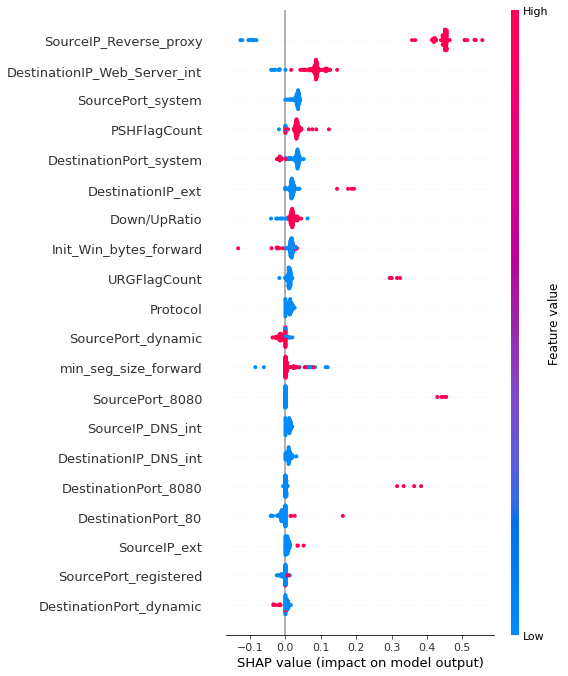

In [ ]:
shap.summary_plot(shap_values[0], data_to_explain)

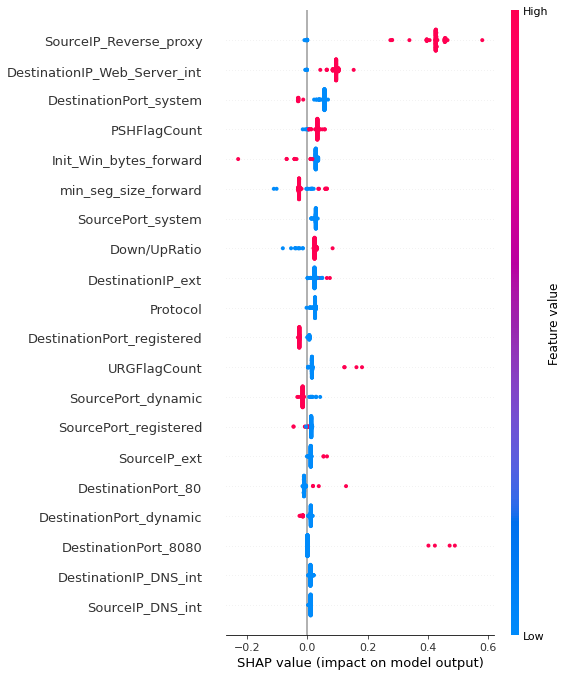

In [ ]:
shap.summary_plot(shap_values_nn[0], data_to_explain)

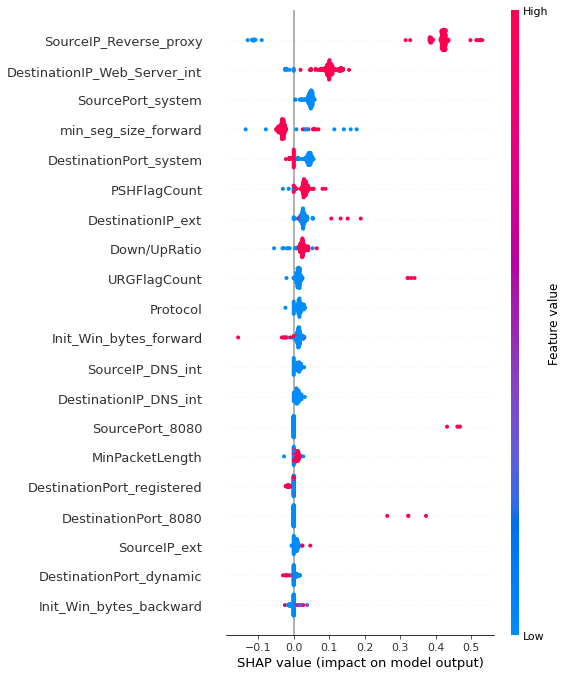

In [ ]:
shap.summary_plot(ric, data_to_explain)

In [ ]:
data_to_explain

,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,DestinationPort_system,SourceIP_DNS_int,SourceIP_Reverse_proxy,SourceIP_Web_Server_int,SourceIP_ext,DestinationIP_DNS_int,DestinationIP_Reverse_proxy,DestinationIP_Web_Server_int,DestinationIP_b_m_cast,DestinationIP_ext
1886687,-0.739684,-0.438984,-0.011316,-0.009581,-0.047734,-0.007192,-0.287074,-0.275825,-0.028022,-0.030625,...,-1.113137,-0.344217,2.015783,-0.243922,-0.383101,-0.56553,-0.131432,1.908995,-0.050353,-0.607880
1886550,-0.739684,-0.438983,-0.011316,-0.009581,-0.047734,-0.007192,-0.287074,-0.275825,-0.028022,-0.030625,...,-1.113137,-0.344217,2.015783,-0.243922,-0.383101,-0.56553,-0.131432,1.908995,-0.050353,-0.607880
1886565,-0.739684,-0.438984,-0.011316,-0.009581,-0.047734,-0.007192,-0.287074,-0.275825,-0.028022,-0.030625,...,0.898362,-0.344217,2.015783,-0.243922,-0.383101,-0.56553,-0.131432,1.908995,-0.050353,-0.607880
262573,-0.739684,-0.261046,-0.000187,-0.004355,0.001232,-0.005557,-0.020731,-0.308700,-0.012955,0.004951,...,-1.113137,-0.344217,-0.496085,-0.243922,-0.383101,-0.56553,-0.131432,-0.523836,-0.050353,1.645061
1886071,-0.739684,-0.438983,-0.011316,-0.009581,-0.047734,-0.007192,-0.287074,-0.275825,-0.028022,-0.030625,...,-1.113137,-0.344217,2.015783,-0.243922,-0.383101,-0.56553,-0.131432,1.908995,-0.050353,-0.607880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886218,-0.739684,-0.438983,-0.011316,-0.009581,-0.047734,-0.007192,-0.287074,-0.275825,-0.028022,-0.030625,...,-1.113137,-0.344217,2.015783,-0.243922,-0.383101,-0.56553,-0.131432,1.908995,-0.050353,-0.607880
1885779,-0.739684,-0.438984,-0.011316,-0.009581,-0.047734,-0.007192,-0.287074,-0.275825,-0.028022,-0.030625,...,-1.113137,-0.344217,2.015783,-0.243922,-0.383101,-0.56553,-0.131432,1.908995,-0.050353,-0.607880
1886620,-0.739684,-0.438984,-0.011316,-0.009581,-0.047734,-0.007192,-0.287074,-0.275825,-0.028022,-0.030625,...,-1.113137,-0.344217,2.015783,-0.243922,-0.383101,-0.56553,-0.131432,1.908995,-0.050353,-0.607880
1886725,-0.739684,-0.438984,-0.011316,-0.009581,-0.047734,-0.007192,-0.287074,-0.275825,-0.028022,-0.030625,...,-1.113137,-0.344217,2.015783,-0.243922,-0.383101,-0.56553,-0.131432,1.908995,-0.050353,-0.607880


In [ ]:


import copy
shap.plots.beeswarm(copy.deepcopy(explanation_object))

In [ ]:
s = np.random.choice(q, 1, replace=False).squeeze()

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[0][s], feature_names=features_train.columns, link='identity')

In [ ]:
shap.initjs()
shap.force_plot(explainer_s.expected_value,shap_values_s[0][s], feature_names=features_train.columns, link='identity')

In [ ]:
shap.initjs()
shap.force_plot(explainer_k.expected_value,shap_values_k[0][s], feature_names=features_train.columns, link='identity')

In [ ]:
shap.initjs()
shap.force_plot(explainer_nn.expected_value.numpy(),shap_values_nn[0][s], feature_names=features_train.columns,link='identity')

In [ ]:
shap.initjs()
shap.force_plot(explainer_nn_s.expected_value.numpy(),shap_values_nn_s[0][s], feature_names=features_train.columns,link='identity')

In [ ]:
shap.initjs()
shap.force_plot(explainer_nn_k.expected_value.numpy(),shap_values_nn_k[0][s], feature_names=features_train.columns,link='identity')